#Анализ тональности

###Импорты

In [24]:
%matplotlib inline

import json
import numpy
import matplotlib.pyplot as plot

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

###Функция для F1 меры

In [25]:
def f1_measure(P,R):
    return [2*x*y/(x+y) for x,y in zip(P, R)]

###Чтение файлов, bag of words, множество ответов

In [26]:
with open('/Users/ermakovpetr/projects/posneg/pos_reviews.json') as data_file:    
    data_pos = json.load(data_file)
with open('/Users/ermakovpetr/projects/posneg/neg_reviews.json') as data_file:    
    data_neg = json.load(data_file)

pos_texts = data_pos.keys()
neg_texts = data_neg.keys()
all_texts = pos_texts + neg_texts

N_POS_TEXT = len(pos_texts)
N_NEG_TEXT = len(neg_texts)
target = [1]*N_POS_TEXT + [0]*N_NEG_TEXT

###Матрица частотности

In [27]:
count_vect = CountVectorizer()
temp_matrix = count_vect.fit_transform(all_texts)
matrix_counts = temp_matrix.toarray()

###Бинарная матрица встречаемости

In [28]:
count_vect_bin = CountVectorizer(binary=True)
matrix_counts_bin = count_vect_bin.fit_transform(all_texts).toarray()

###TF-IDF матрица

In [29]:
tfidf_transformer = TfidfTransformer()
matrix_tfidf = tfidf_transformer.fit_transform(temp_matrix).toarray()

###Relevance Frequency

In [30]:
def get_after_rf_matrix(in_matrix, in_matrix_bin, IN_N_POS_TEXTS, IN_N_NEG_TEXTS, out_n_features):
    '''first text in all matrix mast be positive'''
    pos_rf_prepare = in_matrix_bin[:IN_N_POS_TEXTS].sum(axis=0) 
    neg_rf_prepare = in_matrix_bin[IN_N_POS_TEXTS:].sum(axis=0)
    pos_rf = numpy.array([math.log( 2 + (x / max(1,y)) , 2) for x,y in zip(pos_rf_prepare, neg_rf_prepare)])
    neg_rf = numpy.array([math.log( 2 + (x / max(1,y)) , 2) for x,y in zip(neg_rf_prepare, pos_rf_prepare)])
    l_pos = pos_rf.argsort()[out_n_features//2:]
    l_neg = neg_rf.argsort()[out_n_features//2:]
    return (in_matrix.transpose()[list(set(l_pos) | set(l_neg))]).transpose()

###Кросс-валидация

In [36]:
def cross_valid(matrix_counts, target, test_size=0.3, random_state=0):
    X_train, X_test, Y_train, Y_test = train_test_split(matrix_counts, target, test_size=0.3, random_state=0)
    return (X_train, X_test, Y_train, Y_test)

###Логистическая регрессия

In [101]:
def logistic_reg(X_train, X_test, Y_train, **kwargs):
    model_logistic = LogisticRegression(**kwargs)
    model_logistic.fit(X_train, Y_train)
    predicted = model_logistic.predict_proba(X_test)
    return predicted
    
def logistic_reg_pr(Y_test, predicted, label='?'):
    precision, recall, _ = metrics.precision_recall_curve(Y_test, predicted[:,1])
    plot.plot(recall, precision, label='R-P '+label);
    plot.plot(recall, f1_measure(precision, recall), label='F1 '+label)
    plot.xlabel('Recall'); plot.ylabel('Precision'); plot.title('Logistic Regression, Recall-Precision')
    plot.legend(bbox_to_anchor=(1, 1), loc=2); plot.xlim([0.0, 1.0]); plot.ylim([0.0, 1]);

def logistic_reg_roc(Y_test, predicted, label='?'):
    fpr, tpr, _ = metrics.roc_curve(Y_test, predicted[:,1])
    plot.plot(fpr, tpr, label=label);
    plot.xlabel('Recall'); plot.ylabel('Precision'); plot.title('Logistic Regression, ROC')
    plot.legend(bbox_to_anchor=(1, 1), loc=2); plot.xlim([0.0, 1.0]); plot.ylim([0.0, 1]);
    print 'Logistic Regression (', label, ') AUC = ', metrics.auc(fpr, tpr)

###Деление выборки

In [102]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)

###Логистическая регрессия на всех данных

In [103]:
logreg_1_predicted = logistic_reg(X_train, X_test, Y_train)

###Логистическая регрессия на всех данных, penalty='l1'

In [104]:
logreg_2_predicted = logistic_reg(X_train, X_test, Y_train, penalty='l1')

###Сравнения логистической регрессии

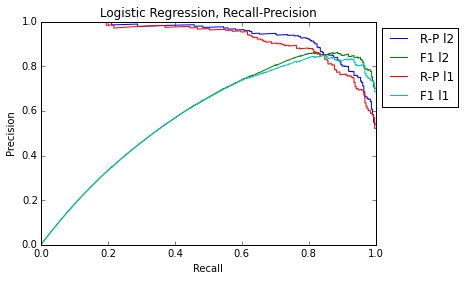

In [105]:
logistic_reg_pr(Y_test, logreg_1_predicted, label='l2'); logistic_reg_pr(Y_test, logreg_2_predicted, label='l1')

Logistic Regression ( l2 ) AUC =  0.931306706992
Logistic Regression ( l1 ) AUC =  0.912170877068


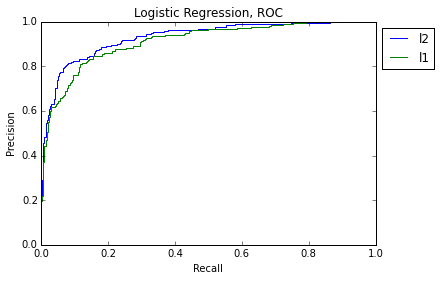

In [106]:
logistic_reg_roc(Y_test, logreg_1_predicted, label='l2'); logistic_reg_roc(Y_test, logreg_2_predicted, label='l1')